# 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score, accuracy_score,  make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import seaborn as sns
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

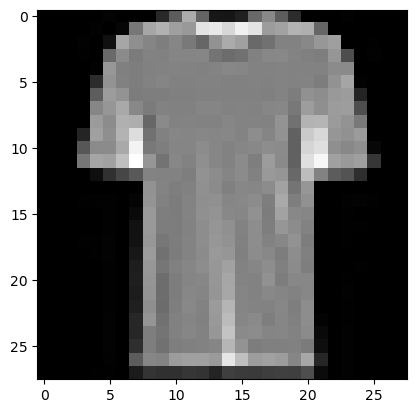

In [3]:
#first picture in the training data
curr_img = np.reshape(train_data[0][:-1], (28,28))
plt.imshow(curr_img, cmap=plt.cm.gray);

# PCA Dimensionality Reduction

> Below code for PCA is an implementation from DataCamp.com on 'Principal Component Analysis (PCA) in Python Tutorial'

In [4]:
train_df = pd.DataFrame(train_data)
# train_df.iloc[:,-1]
train_df.iloc[:,-1].replace(0, 'Top',inplace=True)
train_df.iloc[:,-1].replace(1, 'Trouser',inplace=True)
train_df.iloc[:,-1].replace(2, 'Pullover',inplace=True)
train_df.iloc[:,-1].replace(3, 'Dress',inplace=True)
train_df.iloc[:,-1].replace(4, 'Shirt',inplace=True)

In [5]:
x = train_df.loc[:, :783].values
x = preprocessing.StandardScaler().fit_transform(x)
x.shape

(10000, 784)

In [6]:
pca = decomposition.PCA()
pca_train = pca.fit_transform(x)

In [7]:
labels = ['PC' + str(a) for a in range(1, len(pca_train[0])+1)]
pca_df = pd.DataFrame(pca_train, columns = labels)

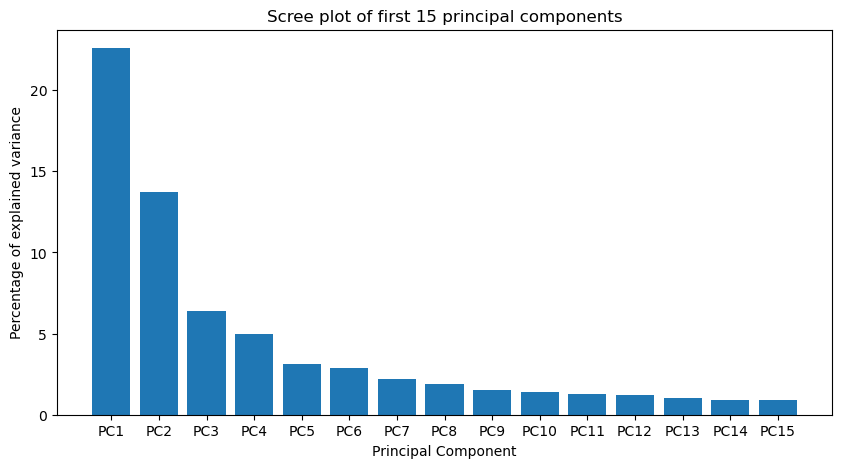

In [8]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.figure(figsize=(10,5))
plt.bar(x=range(1, 16), height = per_var[:15], tick_label=labels[:15])
plt.xlabel('Principal Component')
plt.ylabel('Percentage of explained variance')
plt.title('Scree plot of first 15 principal components')
plt.show()

In [9]:
print('Explained variation per first two principal components: {}'.format(per_var[0:2]))

Explained variation per first two principal components: [22.6 13.7]


<Figure size 640x480 with 0 Axes>

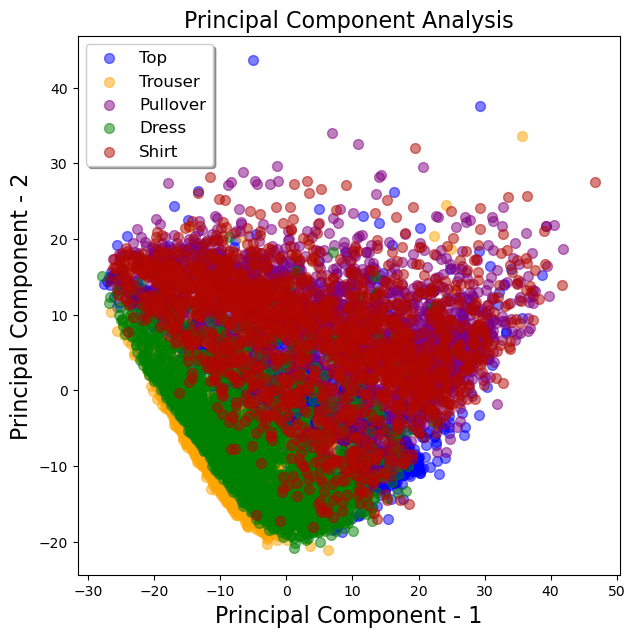

In [10]:
plt.figure()
plt.figure(figsize=(7,7))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Principal Component - 1',fontsize=16)
plt.ylabel('Principal Component - 2',fontsize=16)
plt.title("Principal Component Analysis",fontsize=16)
targets = ['Top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
colors = ['b', 'orange', 'purple', 'g', '#B10701']
for target, color in zip(targets,colors):
    indicesToKeep = train_df.iloc[:,-1] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'PC1']
               , pca_df.loc[indicesToKeep, 'PC2'], c = color, s = 50, alpha=0.5)

plt.legend(targets,prop={'size': 12}, shadow = True);

# LDA dimensionality reduction

> Using sklearn library for reference, if our code works properly

In [11]:
y = train_df.iloc[:,-1]
lda = LinearDiscriminantAnalysis()
lda_train = lda.fit_transform(x,y)

In [12]:
labels = ['LD_var_' + str(a) for a in range(1, len(lda_train[0])+1)]
lda_df = pd.DataFrame(lda_train, columns = labels)

In [13]:
lda_df

,LD_var_1,LD_var_2,LD_var_3,LD_var_4
0,-2.566698,0.556999,-1.853492,-1.649051
1,5.200266,-1.052919,-0.304277,0.403187
2,-1.947182,0.489225,-4.088625,-3.024362
3,-0.526337,1.277373,1.239752,0.239821
4,-0.848720,-0.492582,-0.640027,3.518901
...,...,...,...,...
9995,-2.378782,0.590585,-1.133377,0.246795
9996,-1.609139,0.184289,-1.507037,2.201470
9997,-0.220865,3.503316,1.788161,-0.217823
9998,-1.430544,0.892340,-1.819064,-1.694346


<Figure size 640x480 with 0 Axes>

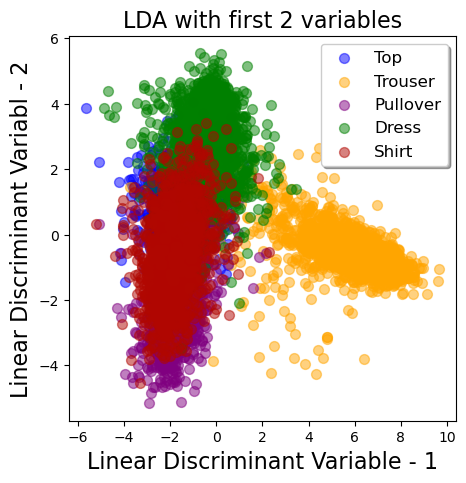

In [14]:
plt.figure()
plt.figure(figsize=(5,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Linear Discriminant Variable - 1',fontsize=16)
plt.ylabel('Linear Discriminant Variabl - 2',fontsize=16)
plt.title("LDA with first 2 variables",fontsize=16)
targets = ['Top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
colors = ['b', 'orange', 'purple', 'g', '#B10701']
for target, color in zip(targets,colors):
    indicesToKeep = train_df.iloc[:,-1] == target
    plt.scatter(lda_df.loc[indicesToKeep, 'LD_var_1']
               , lda_df.loc[indicesToKeep, 'LD_var_2'], c = color, s = 50, alpha=0.5)

plt.legend(targets,prop={'size': 12}, shadow = True);

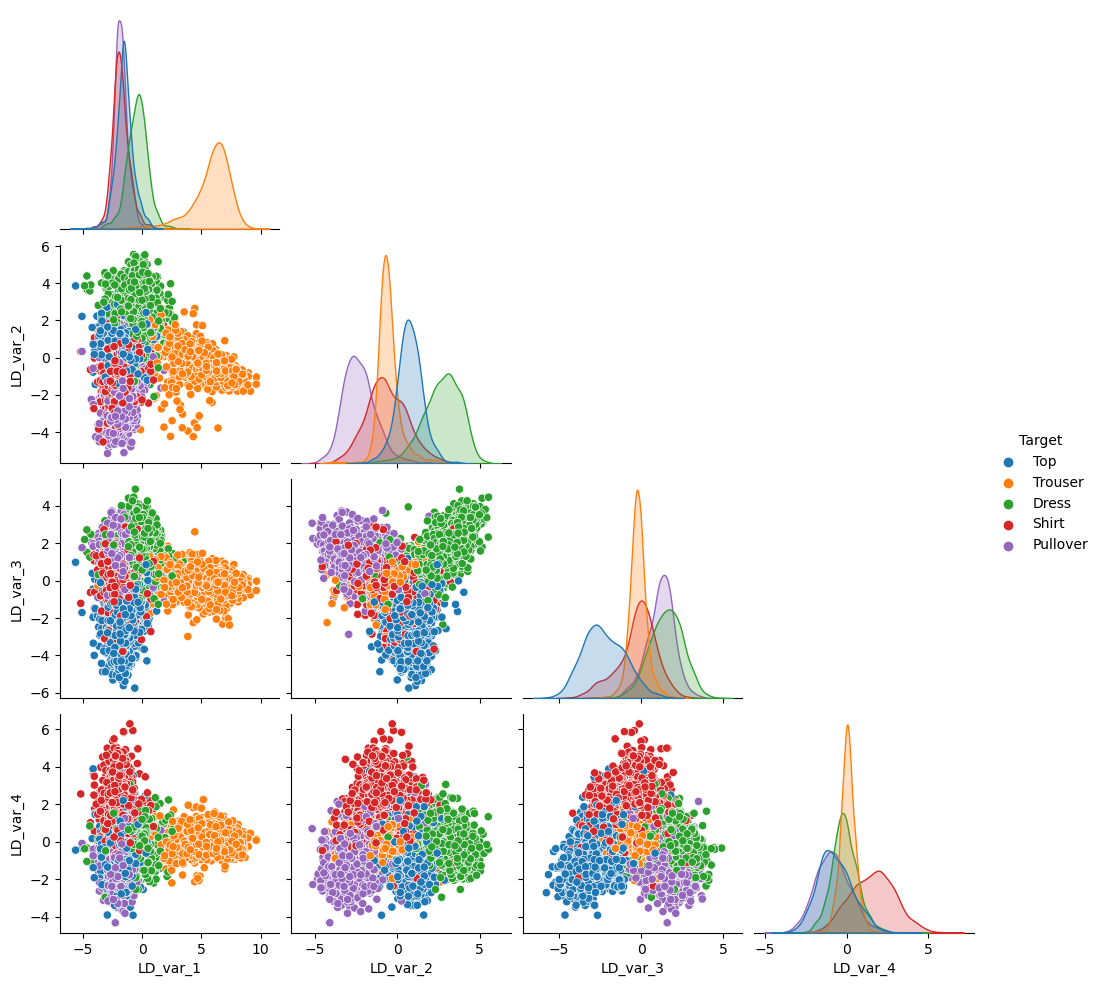

In [15]:
lda_pair = lda_df.copy()
lda_pair['Target'] = y
sns.pairplot(data=lda_pair, hue='Target', corner=True);

> Our own code

In [16]:
# MEAN VECTORS

X = train_data[:,:784]
num_classes = 5
labels = {0:'Top',1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Shirt'}
mean_vectors = []

for i in range(num_classes):
    mean_vectors.append(np.mean(X[y==labels[i]], axis=0))

mean_vectors_array = np.array(mean_vectors)

In [17]:
# WITHIN-CLASS SCATTER

num_features = len(mean_vectors[0])

within_class_scatter = np.zeros((num_features, num_features))
for c,m in zip(range(num_classes), mean_vectors):
    class_scatter = np.zeros((num_features,num_features))
    for x in X[y == labels[c]]:
        x,m = x.reshape(num_features,1), m.reshape(num_features,1)
        class_scatter += (x-m).dot((x-m).T)
    within_class_scatter += class_scatter

within_class_scatter.shape

(784, 784)

In [18]:
# BETWEEN CLASS SCATTER

total_mean = np.mean(X, axis=0)

between_class_scatter = np.zeros((num_features, num_features))

for i,mean_vec in enumerate(mean_vectors):  
    n = X[y== labels[i],:].shape[0]
    mean_vec = mean_vec.reshape(num_features,1) # make column vector
    total_mean = total_mean.reshape(num_features,1) # make column vector
    between_class_scatter += n * (mean_vec - total_mean).dot((mean_vec - total_mean).T)

between_class_scatter.shape

(784, 784)

In [19]:
# GET EIGENVALUES AND EIGENVECTORS

eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(within_class_scatter).dot(between_class_scatter))

for i in range(len(eigenvalues)):
    eigv = eigenvectors[:,i].reshape(num_features,1)
    #np.testing.assert_array_almost_equal(np.linalg.inv(within_class_scatter).dot(between_class_scatter).dot(eigv), eigenvalues[i] * eigv,decimal=6, err_msg='', verbose=True)

In [20]:
# List of tuples (eigenvalue,eigenvctor)
eigval_eigvec = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
eigval_eigvec = sorted(eigval_eigvec, key=lambda k: k[0], reverse=True)

total_eigenvalues = sum(eigenvalues)

print('First 4 eigenvalues')
for i in range(4):
    eigval = eigval_eigvec[i][0]
    print(f'Eigenvalue {i+1}: {round(eigval,4)}')

print('\nVariance explained:')
eigv_sum = sum(eigenvalues)
for i,j in enumerate(eigval_eigvec):
    if i<5:
        print('Eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))
    else:
        break

First 4 eigenvalues
Eigenvalue 1: 8.4004
Eigenvalue 2: 2.7822
Eigenvalue 3: 1.8046
Eigenvalue 4: 0.7584

Variance explained:
Eigenvalue 1: 61.11%
Eigenvalue 2: 20.24%
Eigenvalue 3: 13.13%
Eigenvalue 4: 5.52%
Eigenvalue 5: 0.00%


In [21]:
# chosing K eigenvectors
k =  min(num_features,num_classes-1)

# W matrix
k_eigenvectors = [eigval_eigvec[i][1].reshape(-1,1) for i in range(k)]
W = np.hstack(k_eigenvectors)
W.shape

(784, 4)

In [22]:
# LDA
X_LDA = X.dot(W)
labels = ['LD_var_' + str(a) for a in range(1, len(lda_train[0])+1)]
X_LDA = X_LDA.real
X_LDA = pd.DataFrame(X_LDA, columns = labels)

In [23]:
X_LDA

,LD_var_1,LD_var_2,LD_var_3,LD_var_4
0,-3.071881,0.323908,-2.322965,4.665940
1,10.143353,-2.115297,-0.344393,-0.227038
2,-2.017796,0.221223,-5.177552,7.944977
3,0.399727,1.415355,1.627555,0.162462
4,-0.148798,-1.266324,-0.773194,-7.655572
...,...,...,...,...
9995,-2.752149,0.374794,-1.403274,0.145834
9996,-1.442626,-0.240788,-1.880491,-4.514531
9997,0.919477,4.787907,2.327952,1.253584
9998,-1.138752,0.831987,-2.278994,4.773933


<Figure size 640x480 with 0 Axes>

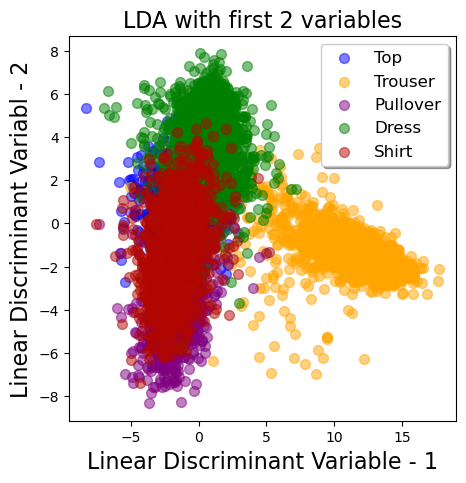

In [24]:
# PLOT FIRST 2 COMPONENTS

plt.figure()
plt.figure(figsize=(5,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Linear Discriminant Variable - 1',fontsize=16)
plt.ylabel('Linear Discriminant Variabl - 2',fontsize=16)
plt.title("LDA with first 2 variables",fontsize=16)
targets = ['Top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
colors = ['b', 'orange', 'purple', 'g', '#B10701']
for target, color in zip(targets,colors):
    indicesToKeep = train_df.iloc[:,-1] == target
    plt.scatter(X_LDA.loc[indicesToKeep, 'LD_var_1']
               , X_LDA.loc[indicesToKeep, 'LD_var_2'], c = color, s = 50, alpha=0.5)

plt.legend(targets,prop={'size': 12}, shadow = True);

# KNN

#### TRAIN/TEST DATA

In [25]:
# X_train_lda, X_test_lda, y_train, y_test

class_mapping = {'Top':0,'Trouser':1,'Pullover':2,'Dress':3,'Shirt':4}

X_train_lda = X_LDA.copy()
#X_train_lda['Target'] = y
X_train_lda = X_train_lda.values

y_train = y.replace(class_mapping)
y_train = y_train.values
y_train = y_train.reshape(-1,1)

# LDA on TESTdata  

testdata = np.load('fashion_test.npy')
test_df = pd.DataFrame(testdata)

x_t = test_df.loc[:, :783].values
x_t = preprocessing.StandardScaler().fit_transform(x_t)
y_t = test_df.iloc[:,-1]

lda_test = lda.transform(x_t)
labels_t = ['LD_var_' + str(a) for a in range(1, len(lda_test[0])+1)]
lda_t_df = pd.DataFrame(lda_test, columns = labels_t)
X_test_lda = lda_t_df.copy()
X_test_lda = X_test_lda.values

y_test = y_t
y_test = y_test.values
y_test = y_test.reshape(-1,1)

#### 2 LDA VAR

In [26]:
X_train_2lda = np.delete(X_train_lda, [2,3], axis=1)
X_test_2lda = np.delete(X_test_lda, [2,3], axis=1)

In [27]:
# CROSS VALIDATION FOR SELECTING K

metrics = {'Accuracy: ': accuracy_score} #F1 SCORE? 
classifiers = { "Knn 1": KNN(1), "Knn 3": KNN(3), "Knn 5": KNN(5), "Knn 9": KNN(9)}


def cross_validate_classifiers(classifiers, X_train, y_train, metrics):
    results = {}

    for clf in classifiers.keys():
        clf_results = {}

        for metric in metrics.keys():
            scores = cross_val_score(classifiers[clf], X_train, y_train, cv=5)
            clf_results[metric] = scores.mean()

        results[clf] = clf_results
    return results

results = cross_validate_classifiers(classifiers,X_train_2lda,y_train.ravel(), metrics)
resultsdf = pd.DataFrame(results)

In [28]:
resultsdf

,Knn 1,Knn 3,Knn 5,Knn 9
Accuracy:,0.6936,0.7394,0.7538,0.7665


In [29]:
#EVALUATION ON TEST DATA 

k= 9
knn_classifier = KNN(k)
knn_classifier = knn_classifier.fit(X_train_2lda,y_train.ravel())

y_pred = knn_classifier.predict(X_test_2lda)
#F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)
print(f'KNN {k} neighbors. Accuracy score: {Accuracy}')

KNN 9 neighbors. Accuracy score: 0.6276


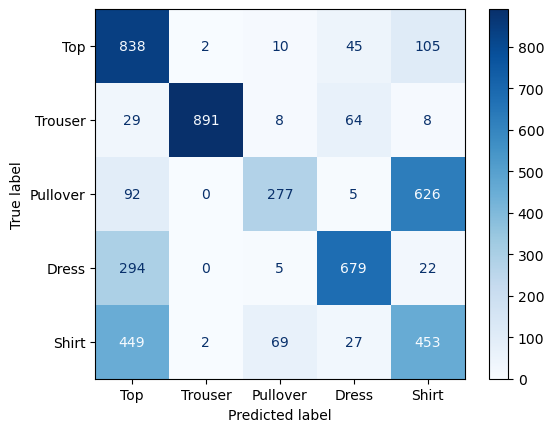

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test,y_pred), display_labels=targets)
disp.plot(cmap='Blues');

In [31]:
# DOUBLE CHECK WITH LDA FROM LIBRARY (NOT OUR CODE)

lda2 = lda_df.values
lda2 = np.delete(lda2, [2,3], axis=1)

#EVALUATION ON TEST DATA 

k= 9
knn_classifier_ = KNN(k)
knn_classifier_ = knn_classifier_.fit(lda2,y_train.ravel())

y_pred = knn_classifier_.predict(X_test_2lda)
#F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)
print(f'KNN {k} neighbors. Accuracy score: {Accuracy}')

print('Why different accuracy, shouldnt be equal? -- check order of lda?')

KNN 9 neighbors. Accuracy score: 0.719
Why different accuracy, shouldnt be equal? -- check order of lda?


#### 3 LDA VAR

In [32]:
X_train_3lda = np.delete(X_train_lda, [3], axis=1)
X_test_3lda = np.delete(X_test_lda, [3], axis=1)

In [33]:
results_3lda = cross_validate_classifiers(classifiers,X_train_3lda,y_train.ravel(), metrics)
resultsdf_3lda = pd.DataFrame(results_3lda)

In [34]:
resultsdf_3lda

,Knn 1,Knn 3,Knn 5,Knn 9
Accuracy:,0.7632,0.7974,0.8107,0.819


In [35]:
#EVALUATION ON TEST DATA 

k= 9
knn_classifier = KNN(k)
knn_classifier = knn_classifier.fit(X_train_3lda,y_train.ravel())

y_pred = knn_classifier.predict(X_test_3lda)
#F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)
print(f'KNN {k} neighbors. Accuracy score: {Accuracy}')

KNN 9 neighbors. Accuracy score: 0.7268


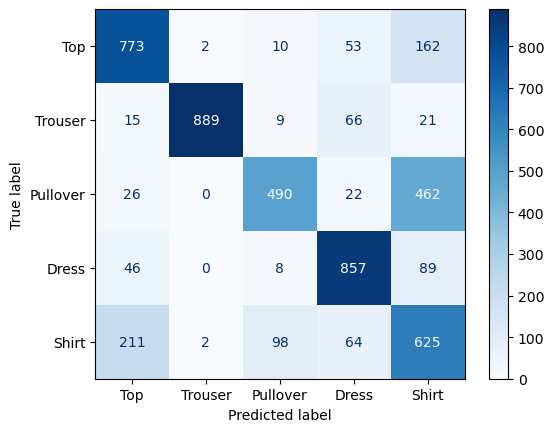

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test,y_pred), display_labels=targets)
disp.plot(cmap='Blues');

#### FULL 4 LDA VAR

In [37]:
results_full = cross_validate_classifiers(classifiers,X_train_lda,y_train.ravel(), metrics)
resultsdf_full = pd.DataFrame(results_full)

In [38]:
resultsdf_full

,Knn 1,Knn 3,Knn 5,Knn 9
Accuracy:,0.8221,0.853,0.8607,0.8697


In [39]:
#EVALUATION ON TEST DATA 

k= 9
knn_classifier = KNN(k)
knn_classifier = knn_classifier.fit(X_train_lda,y_train.ravel())

y_pred = knn_classifier.predict(X_test_lda)
#F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)
print(f'KNN {k} neighbors. Accuracy score: {Accuracy}')

KNN 9 neighbors. Accuracy score: 0.6422


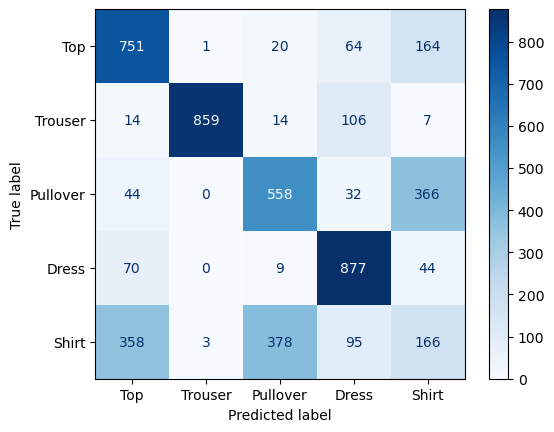

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test,y_pred), display_labels=targets)
disp.plot(cmap='Blues');

# CNN

In [54]:
train_df = pd.DataFrame(train_data)
x_train = train_df.loc[:, :783].values #train_images
y_train = train_df.iloc[:,-1] #train_labels

test_df = pd.DataFrame(test_data)
x_test = test_df.loc[:, :783].values #test_images
y_test = test_df.iloc[:,-1] #test_labels

In [55]:
#reshapeing the dimention of the data so it matches the requirements
x_train = np.array(x_train).reshape((x_train.shape[0], 28, 28, 1))
x_test = np.array(x_test).reshape((x_test.shape[0], 28, 28, 1))

In [56]:
# Normalizing pixel values to be between 0 and 1
# train_data already normalised

x_train, x_test = x_train / 255.0, x_test / 255.0

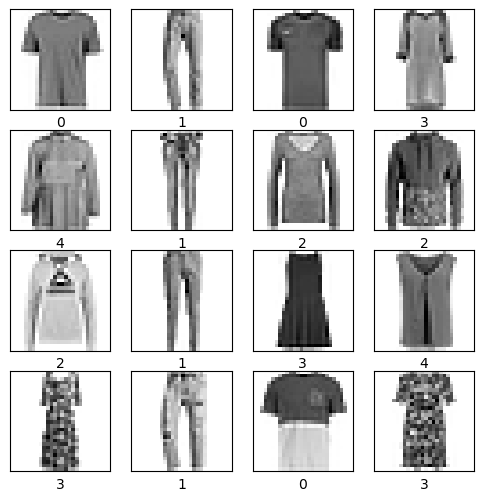

In [57]:
#visualising example images
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
def show():
    plt.figure(figsize=(6,6))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        plt.xlabel(y_train[i])
    plt.show()

show()

In [58]:
#defining CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 5574

What can we see?

- Output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels)

- width and height dimensions show tendency of getting smaller as you go deeper in the network

In [60]:
# for classificatio we use fully connected layer (FN/dense layer) 
model.add(layers.Flatten()) #falttening the image 
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(5))

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [62]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.05128694, -0.01231496,  0.02971135, -0.10806414, -0.04849765]],
      dtype=float32)

The network summary shows that (3, 3, 56) outputs were flattened into vectors of shape (504) before going through two Dense layers.

### Compiling and training the model

In [63]:
#softmax activation function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=100, 
                    validation_data=(x_test, y_test))

Epoch 1/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6865 - accuracy: 0.7081 - val_loss: 0.5320 - val_accuracy: 0.7914
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.4498 - accuracy: 0.8293 - val_loss: 0.4336 - val_accuracy: 0.8400
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.3853 - accuracy: 0.8546 - val_loss: 0.3965 - val_accuracy: 0.8542
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 0.3447 - accuracy: 0.8704 - val_loss: 0.3854 - val_accuracy: 0.8588
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.3186 - accuracy: 0.8774 - val_loss: 0.3726 - val_accuracy: 0.8628
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.2918 - accuracy: 0.8890 - val_loss: 0.3660 - val_accuracy: 0.8642
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 0.2717 - accuracy: 0.8948 - val_loss: 0.3405 - val_accuracy:

157/157 - 1s - loss: 1.4852 - accuracy: 0.8718 - 601ms/epoch - 4ms/step


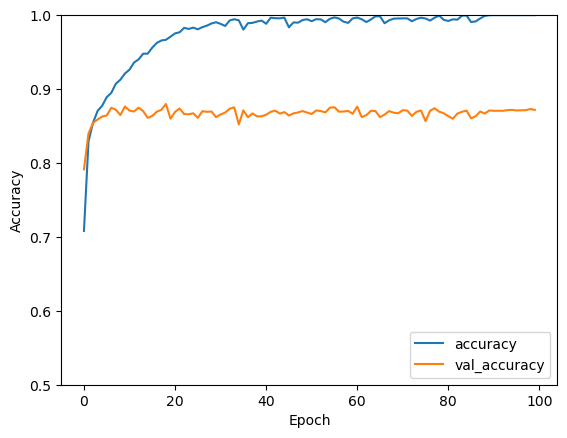

In [64]:
#model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [65]:
print(test_acc)

0.8718000054359436


# Naive Bayes

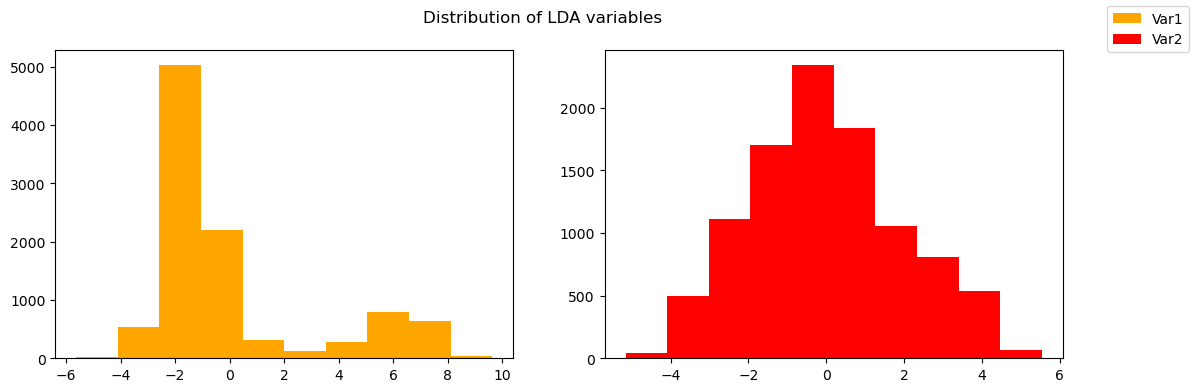

In [66]:
fig, ax = plt.subplots(nrows=1,ncols =2, figsize = (13,4))

ax[0].hist(lda_pair.iloc[:,0], color = 'orange', label = 'Var1')
ax[1].hist(lda_pair.iloc[:,1], color = 'red', label = 'Var2')
#ax[2].hist(lda_pair.iloc[:,2], color = 'purple', label='Var3')
#ax[3].hist(lda_pair.iloc[:,3], label = 'Var4')
fig.legend()
fig.suptitle('Distribution of LDA variables');

In [67]:
#LDA on test
test_data = np.load('fashion_test.npy')
test_df = pd.DataFrame(test_data)
# train_df.iloc[:,-1]
test_df.iloc[:,-1].replace(0, 'Top',inplace=True)
test_df.iloc[:,-1].replace(1, 'Trouser',inplace=True)
test_df.iloc[:,-1].replace(2, 'Pullover',inplace=True)
test_df.iloc[:,-1].replace(3, 'Dress',inplace=True)
test_df.iloc[:,-1].replace(4, 'Shirt',inplace=True)

x_t = test_df.loc[:, :783].values
x_t = preprocessing.StandardScaler().fit_transform(x_t)
y_t = test_df.iloc[:,-1]
lda_t = LinearDiscriminantAnalysis()
lda_test = lda.transform(x_t)
labels_t = ['LD_var_' + str(a) for a in range(1, len(lda_test[0])+1)]
lda_t_df = pd.DataFrame(lda_test, columns = labels_t)
lda_pair_test = lda_t_df.copy()
lda_pair_test['Target'] = y_t

In [68]:
def class_divider(data):
    targets = list(data['Target'].unique())
    classes = {}

    for t in targets:
        classes[t] = data[(data['Target']==t)]

    return classes

In [69]:
def prior_probabilities(data):
    #Dictionary with each class and corresponding class prior

    prior = data['Target'].value_counts()
    targets = list(data['Target'].unique())
    prior_p = {}

    for i,t in enumerate(targets):
        prior_p[t] = prior[i]/len(data['Target'])
    
    return prior_p    

In [70]:
def estimate_pdf(classes): 
    ''' This function estimates the pdf of each feature for each class,nby spliting the 
    range of x into diferent bins, and mapping those bins to a corresponding 
    density'''

    classes_pdf = {}

    for t in classes.keys():
        classes_pdf[t] = {}

        for v in range(classes[t].shape[1]-1):
            np_data = np.array(classes[t].iloc[:,v])
            min_value = np_data.min()
            max_value = np_data.max()

            # Calculate bin width using Scott's Rule
            n_data = len(np_data)
            std_dev = np_data.std()
            h = 3.5 * std_dev / (n_data ** (1/3))

            bins = np.arange(min_value,max_value,h)

            counts, bin_edges = np.histogram(np_data, bins=bins)
            n = sum(counts)
            epsilon = 1e-10  # Small constant to avoid division by zero
            normalized_counts = counts / (n * h + epsilon)
            classes_pdf[t][v] = [normalized_counts, bin_edges]

    return classes_pdf

In [71]:
def calculate_conditional(x, pdf):

    normalized_counts, bin_edges = pdf[0], pdf[1]
    index = np.searchsorted(bin_edges[:-1], x)
    index = min(index, len(normalized_counts) - 1)

    p = normalized_counts[index]

    return p

In [72]:
def class_posterior(row, classes_pdf, prior_probs):
    probs = {}
    prior_p = prior_probs

    for t in targets:
        probs[t] = prior_p[t]
        for v in range(len(row)-1):
            x = row[v]
            pdf = classes_pdf[t][v]
            probs[t] *= calculate_conditional(x, pdf)
    
    prediction = max(probs, key=probs.get)
    
    return prediction

In [73]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [74]:
def accuracy_metric(actual, predicted):
    # Calculate overall accuracy
    overall_accuracy = sum(1 for a, p in zip(actual, predicted) if a == p) / len(actual) * 100.0

    # Calculate class-specific accuracies
    cm = confusion_matrix(actual, predicted)
    class_accuracies = {label: cm[i, i] / cm[i, :].sum() * 100.0 for i, label in enumerate(set(actual))}

    # Print overall accuracy
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

    # Print class-specific accuracies
    print("\nClass-specific Accuracies:")
    for label, acc in class_accuracies.items():
        print(f"{label}:  {acc:.2f}%")

    return class_accuracies


In [75]:
def NaiveBayes(train_data, test_data):
    predicted = []
    classes = class_divider(train_data)
    prior_p = prior_probabilities(train_data)
    classes_pdf = estimate_pdf(classes)
    for _,row in test_data.iterrows():
        prediction = class_posterior(row, classes_pdf, prior_p)
        predicted.append(prediction)
    return predicted

In [76]:
final_train = lda_pair[['LD_var_1', 'LD_var_2', 'Target']]
final_test = lda_pair_test[['LD_var_1', 'LD_var_2', 'Target']]

In [77]:
prediction = NaiveBayes(final_train, final_test)

print(accuracy_metric(y_t, prediction))


Overall Accuracy: 71.16%

Class-specific Accuracies:
Trouser:  84.80%
Dress:  64.60%
Top:  40.00%
Shirt:  71.10%
Pullover:  95.30%
{'Trouser': 84.8, 'Dress': 64.60000000000001, 'Top': 40.0, 'Shirt': 71.1, 'Pullover': 95.3}


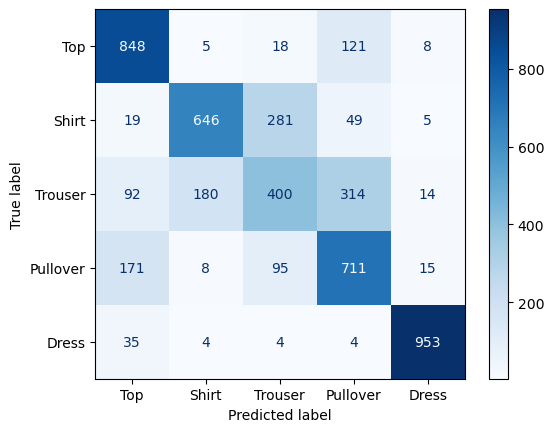

In [78]:
classess = ['Top','Shirt','Trouser','Pullover','Dress']
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_t,prediction), display_labels=classess)
disp.plot(cmap='Blues');

In [79]:
correlations_by_class = final_train.groupby('Target').apply(lambda x: x[['LD_var_1', 'LD_var_2']].corr().iloc[0, 1])

correlations_table = pd.DataFrame(correlations_by_class, columns=['Correlation'])
accuracy_dict = accuracy_metric(y_t, prediction)
correlations_table['Accuracy'] = correlations_table.index.map(accuracy_dict)
correlations_table



Overall Accuracy: 71.16%

Class-specific Accuracies:
Trouser:  84.80%
Dress:  64.60%
Top:  40.00%
Shirt:  71.10%
Pullover:  95.30%


,Correlation,Accuracy
Target,,
Dress,0.085041,64.6
Pullover,0.374024,95.3
Shirt,0.314111,71.1
Top,0.038135,40.0
Trouser,-0.534075,84.8


### Class distribution plot

In [80]:
train_df = pd.DataFrame(train_data)
train_df.iloc[:,-1]
train_df.iloc[:,-1].replace(0, 'Top',inplace=True)
train_df.iloc[:,-1].replace(1, 'Trouser',inplace=True)
train_df.iloc[:,-1].replace(2, 'Pullover',inplace=True)
train_df.iloc[:,-1].replace(3, 'Dress',inplace=True)
train_df.iloc[:,-1].replace(4, 'Shirt',inplace=True)


In [81]:
test_df = pd.DataFrame(test_data)
test_df.iloc[:,-1]
test_df.iloc[:,-1].replace(0, 'Top',inplace=True)
test_df.iloc[:,-1].replace(1, 'Trouser',inplace=True)
test_df.iloc[:,-1].replace(2, 'Pullover',inplace=True)
test_df.iloc[:,-1].replace(3, 'Dress',inplace=True)
test_df.iloc[:,-1].replace(4, 'Shirt',inplace=True)


In [82]:
# Unique classes and their counts
# in test set
unique_test, counts_test = np.unique(test_df.iloc[:,-1], return_counts=True)
# in train set
unique_train, counts_train = np.unique(train_df.iloc[:,-1], return_counts=True)
print("Unique classes and their counts:", dict(zip(unique_train, counts_train)))
print("Unique classes and their counts:", dict(zip(unique_test, counts_test)))

Unique classes and their counts: {'Dress': 2005, 'Pullover': 2001, 'Shirt': 2014, 'Top': 2033, 'Trouser': 1947}
Unique classes and their counts: {'Dress': 1000, 'Pullover': 1000, 'Shirt': 1000, 'Top': 1000, 'Trouser': 1000}


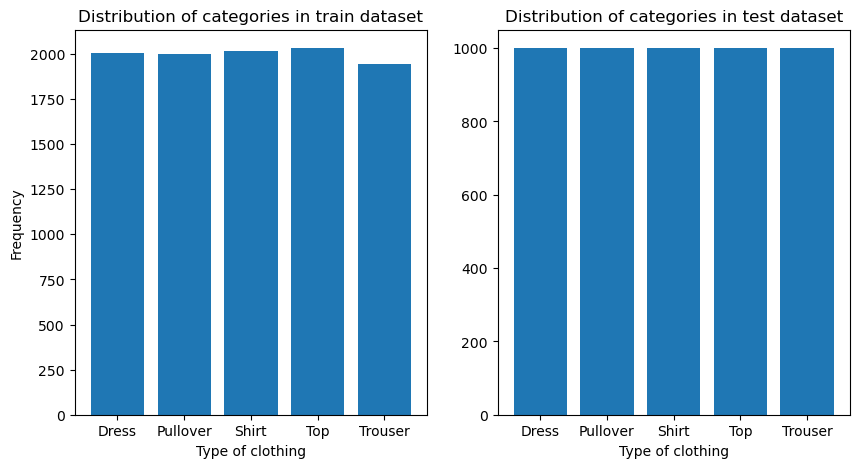

<function matplotlib.pyplot.show(close=None, block=None)>

In [83]:
# Create the first subplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(unique_train, counts_train)
plt.xticks(unique_train)
plt.xlabel("Type of clothing")
plt.ylabel("Frequency")
plt.title("Distribution of categories in train dataset")
 
# Create the second subplot
plt.subplot(1, 2, 2)
plt.bar(unique_test, counts_test)
plt.xticks(unique_test)
plt.xlabel("Type of clothing")
# plt.ylabel("Frequency")
plt.title("Distribution of categories in test dataset")
plt.show()
 
# Display the plot
plt.show